# Confidence Bands

In [1]:
% matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import emcee
import corner
from scipy import optimize
from scipy import stats

Standard scaler for x = 3.40035
Standard scaler for y = 13.78845
-2.8331616036936023


<IPython.core.display.Javascript object>


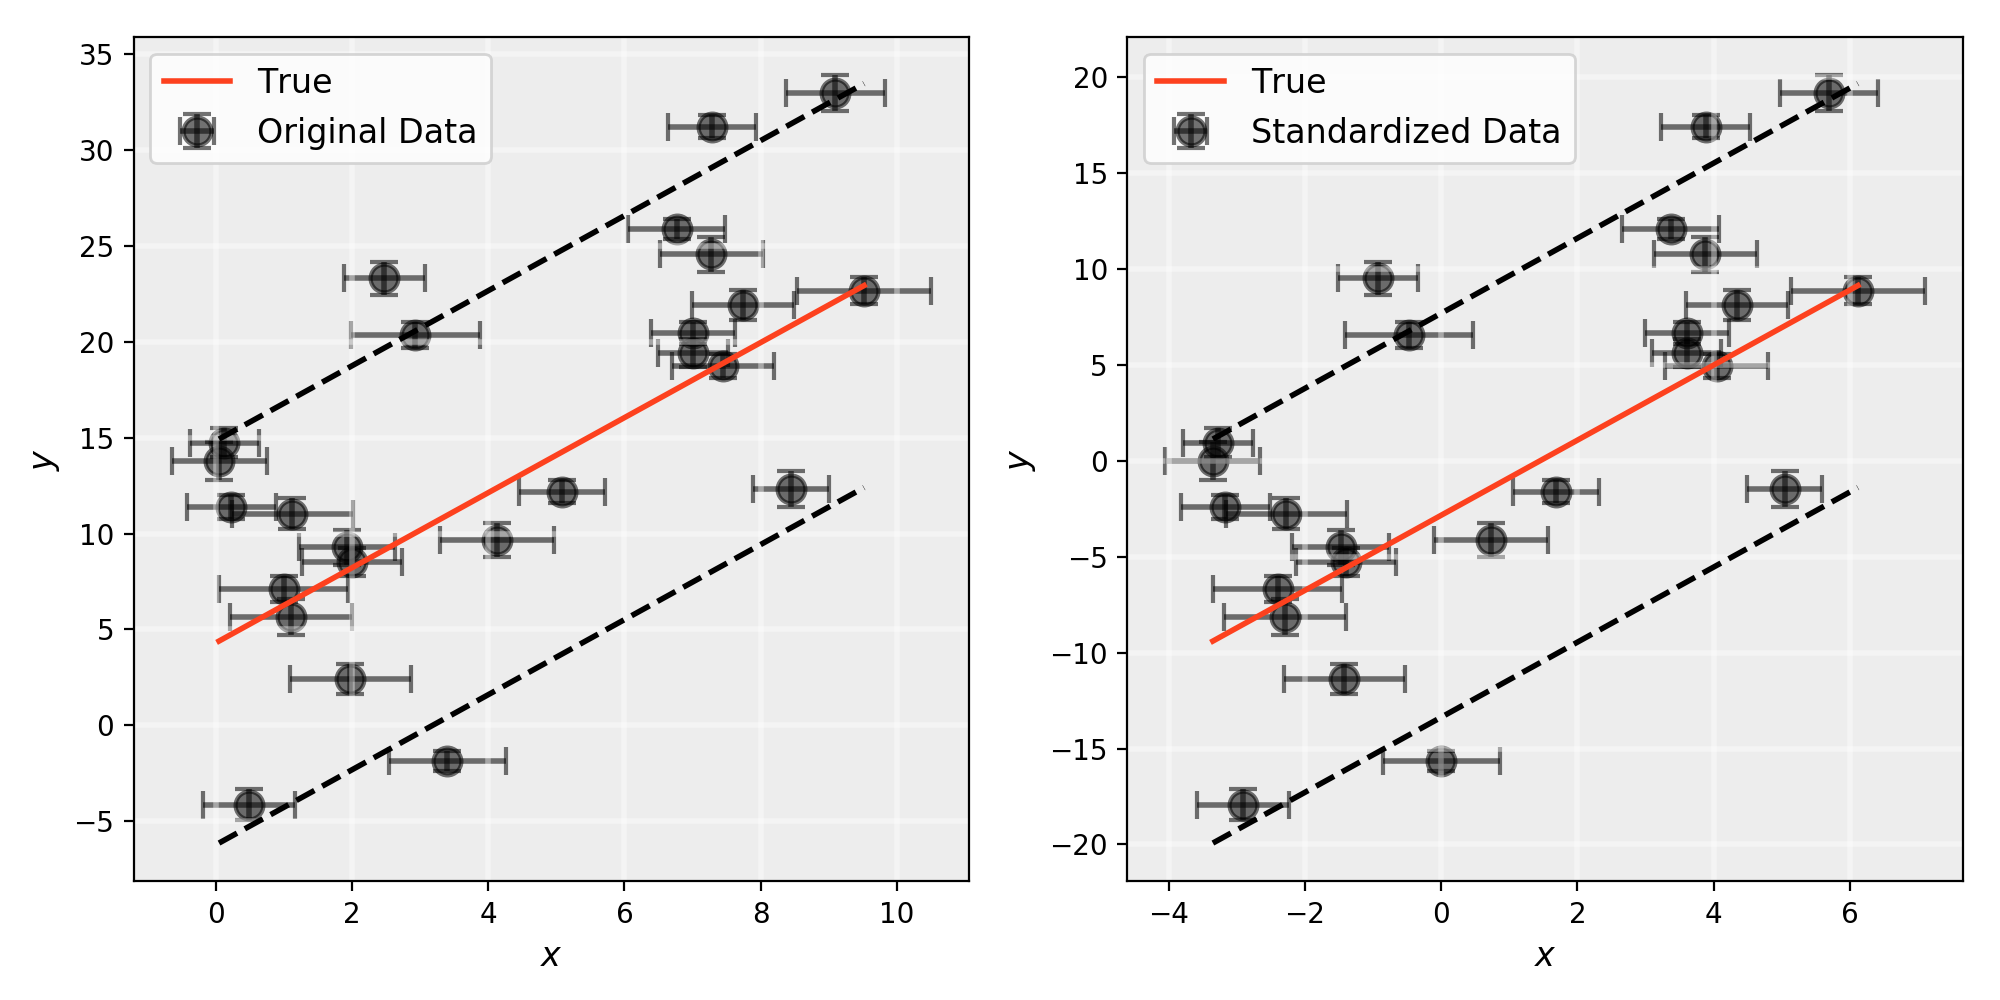

In [2]:
# Choose the "true" parameters.
m_true = 1.959
b_true = 4.294
f_true = 10.534

# Generate some synthetic data from the model.
np.random.seed(666)
N = 25
x = np.sort(10*np.random.rand(N))
# Random errors
yerr = 0.5+0.5*np.random.rand(N)
xerr = 0.5+0.5*np.random.rand(N)
# Constant errors
# xerr = np.full_like(x,0.001)
# yerr = np.full_like(x,0.001)
y = m_true*x+b_true
for i in range(0,len(y),1):
    r = np.random.normal(0.0,f_true)
#     print r
    y[i] += r
# We need to standardize the data such that is has a mean (or median) of zero
# Standardized data is used for fitting, so pass X and Y to regression algorithm
standard_scalar_x = np.median(x)
standard_scalar_y = np.median(y)

print('Standard scaler for x = %0.5f' % standard_scalar_x )
print('Standard scaler for y = %0.5f' % standard_scalar_y )

X = x - standard_scalar_x
Y = y - standard_scalar_y
b_new = b_true - standard_scalar_y - m_true*(-standard_scalar_x)
print b_new
y_new = m_true*X + b_new
########################################################################################################################################################

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
ax2 = fig.add_subplot(1,2,2)
ax2.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
fontsize=12

ax1.errorbar(x,y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Original Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)
ax1.plot(x,m_true*x+b_true,color='xkcd:orange red',linewidth=2,label='True',zorder=2)
ax1.plot(x,m_true*x+b_true+f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax1.plot(x,m_true*x+b_true-f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax1.set_xlabel('$x$',fontsize=fontsize)
ax1.set_ylabel('$y$',fontsize=fontsize)
ax1.legend(loc='best',fontsize=fontsize)

ax2.errorbar(X,Y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Standardized Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)
ax2.plot(X,y_new,color='xkcd:orange red',linewidth=2,label='True',zorder=2)
ax2.plot(X,y_new+f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax2.plot(X,y_new-f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax2.set_xlabel('$x$',fontsize=fontsize)
ax2.set_ylabel('$y$',fontsize=fontsize)
ax2.legend(loc='best',fontsize=fontsize)
plt.tight_layout()

<IPython.core.display.Javascript object>


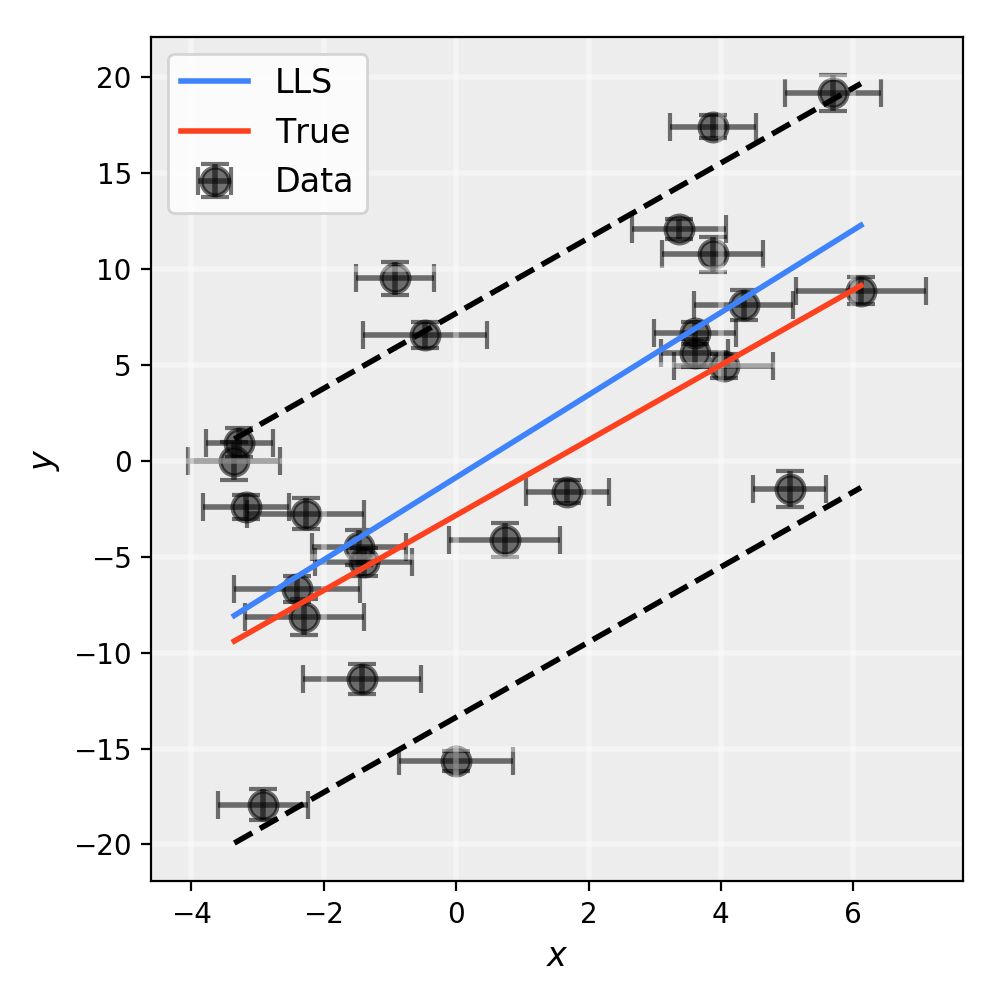


--------------------------
 True values
--------------------------
     slope, m = 1.959
 intercept, b = 4.294
   scatter, f = 10.534
--------------------------
 Linear Least-Squares
--------------------------
     slope, m = 2.151
 intercept, b = -0.860
--------------------------



In [3]:
A = np.vstack((np.ones_like(X), X)).T
C = np.diag(yerr * yerr)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, Y)))
# Shift standardized parameters to data space
y_ls = m_ls*(X)+(b_ls)
########################################################################################################################################################

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
fontsize=12

ax1.errorbar(X,Y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)
ax1.plot(X,y_ls           ,color='xkcd:dodger blue',linewidth=2,label='LLS',zorder=3)

ax1.plot(X,y_new,color='xkcd:orange red',linewidth=2,label='True',zorder=2)
ax1.plot(X,y_new+f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax1.plot(X,y_new-f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)


ax1.set_xlabel('$x$',fontsize=fontsize)
ax1.set_ylabel('$y$',fontsize=fontsize)
ax1.legend(loc='best',fontsize=fontsize)
plt.tight_layout()

########################################################################################################################################################

print("""
--------------------------
 True values
--------------------------
     slope, m = %0.3f
 intercept, b = %0.3f
   scatter, f = %0.3f
--------------------------
 Linear Least-Squares
--------------------------
     slope, m = %0.3f
 intercept, b = %0.3f
--------------------------
""" % (m_true,b_true,f_true,\
       m_ls,b_ls))

In [4]:
#Likelihood 1: errors on x and y with intrinsic scatter f
def lnlike1(theta, X, Y, xerr, yerr):
    m, b, lnf = theta
    model = m * X + b
    inv_sigma2 = 1.0/(yerr**2 + m**2*xerr**2 + np.exp(2*lnf))
    return -0.5*(np.sum((Y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

In [5]:
nll = lambda *args: -lnlike1(*args)
result = optimize.minimize(nll, [m_true, b_true, np.log(f_true)], args=(X, Y, xerr, yerr))
m_ml, b_ml, lnf_ml = result["x"]
y_ml = m_ml*(X)+(b_ml)

<IPython.core.display.Javascript object>


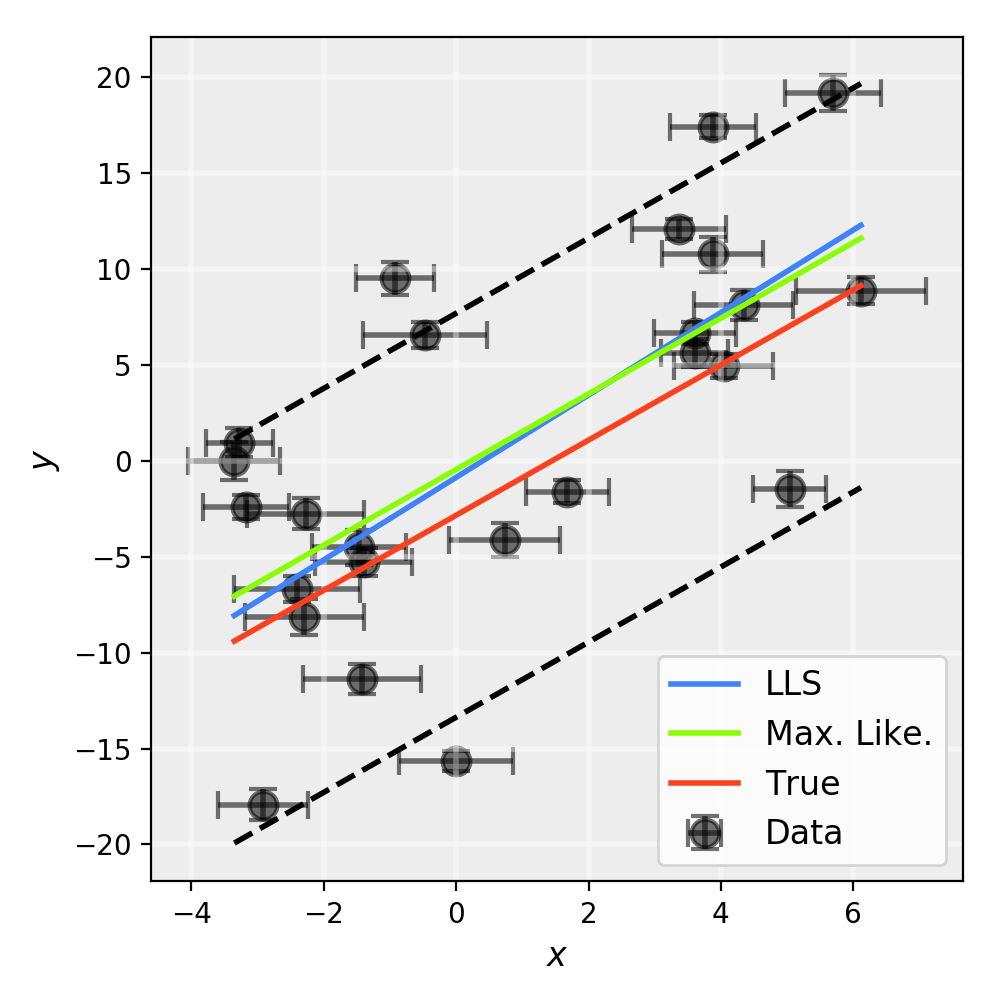


--------------------------
 True values
--------------------------
     slope, m = 1.959
 intercept, b = 4.294
   scatter, f = 10.534
--------------------------
 Linear Least-Squares
--------------------------
     slope, m = 2.151
 intercept, b = -0.860
--------------------------
 Max. Likelihood Est.
--------------------------
     slope, m = 1.973
 intercept, b = -0.446
 scatter,   f = 6.725
--------------------------



In [6]:
########################################################################################################################################################

fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(1,1,1)
ax1.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
fontsize=12

ax1.errorbar(X,Y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)
ax1.plot(X,y_ls,color='xkcd:dodger blue',linewidth=2,label='LLS',zorder=3)
ax1.plot(X,y_ml,color='xkcd:lime green',linewidth=2,label='Max. Like.',zorder=4)

ax1.plot(X,y_new,color='xkcd:orange red',linewidth=2,label='True',zorder=2)
ax1.plot(X,y_new+f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)
ax1.plot(X,y_new-f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=2)

ax1.set_xlabel('$x$',fontsize=fontsize)
ax1.set_ylabel('$y$',fontsize=fontsize)
ax1.legend(loc='best',fontsize=fontsize)
plt.tight_layout()

########################################################################################################################################################

print("""
--------------------------
 True values
--------------------------
     slope, m = %0.3f
 intercept, b = %0.3f
   scatter, f = %0.3f
--------------------------
 Linear Least-Squares
--------------------------
     slope, m = %0.3f
 intercept, b = %0.3f
--------------------------
 Max. Likelihood Est.
--------------------------
     slope, m = %0.3f
 intercept, b = %0.3f
 scatter,   f = %0.3f
--------------------------
""" % (m_true,b_true,f_true,\
       m_ls,b_ls,\
       m_ml,b_ml,np.exp(lnf_ml))
)

In [7]:
def lnprior1(theta):
    m, b, lnf = theta
    if -10.0 < m < 10.0 and -20.0 < b < 20.0 and -20.0 < lnf < 10.0:
        return 0.0
    return -np.inf

def lnprob1(theta, X, Y, xerr, yerr):
    lp = lnprior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike1(theta, X, Y, xerr, yerr)

ndim, nwalkers = 3, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(X, Y, xerr, yerr))

sampler.run_mcmc(pos, 500)

(array([[ 1.2141619 ,  0.94021856,  1.95304204],
        [ 2.3658104 ,  0.20847783,  1.96956215],
        [ 1.8081485 , -0.53211926,  1.94332088],
        ...,
        [ 0.96862693,  1.3879145 ,  1.97021681],
        [ 2.50561581, -0.53674258,  2.01387378],
        [ 2.58872495, -3.84524232,  2.12278278]]),
 array([-62.44409503, -61.53750021, -60.96087527, -62.33544363,
        -62.22130151, -63.30263618, -61.87376533, -62.54317396,
        -67.58777674, -62.38472422, -62.15240278, -61.1251211 ,
        -62.2892396 , -64.27649776, -62.071996  , -63.65343083,
        -61.45392136, -62.77199815, -62.99916473, -61.25395672,
        -62.11038024, -65.84936244, -61.93430377, -68.02685844,
        -61.66567314, -60.98741351, -61.76246566, -61.29543089,
        -63.10204051, -62.73689285, -62.87708048, -62.32843383,
        -63.35681   , -61.56129147, -61.38138874, -62.58313215,
        -61.2688881 , -61.37388003, -61.0235954 , -61.99840956,
        -61.4958988 , -62.06826356, -62.35661163, -

<IPython.core.display.Javascript object>


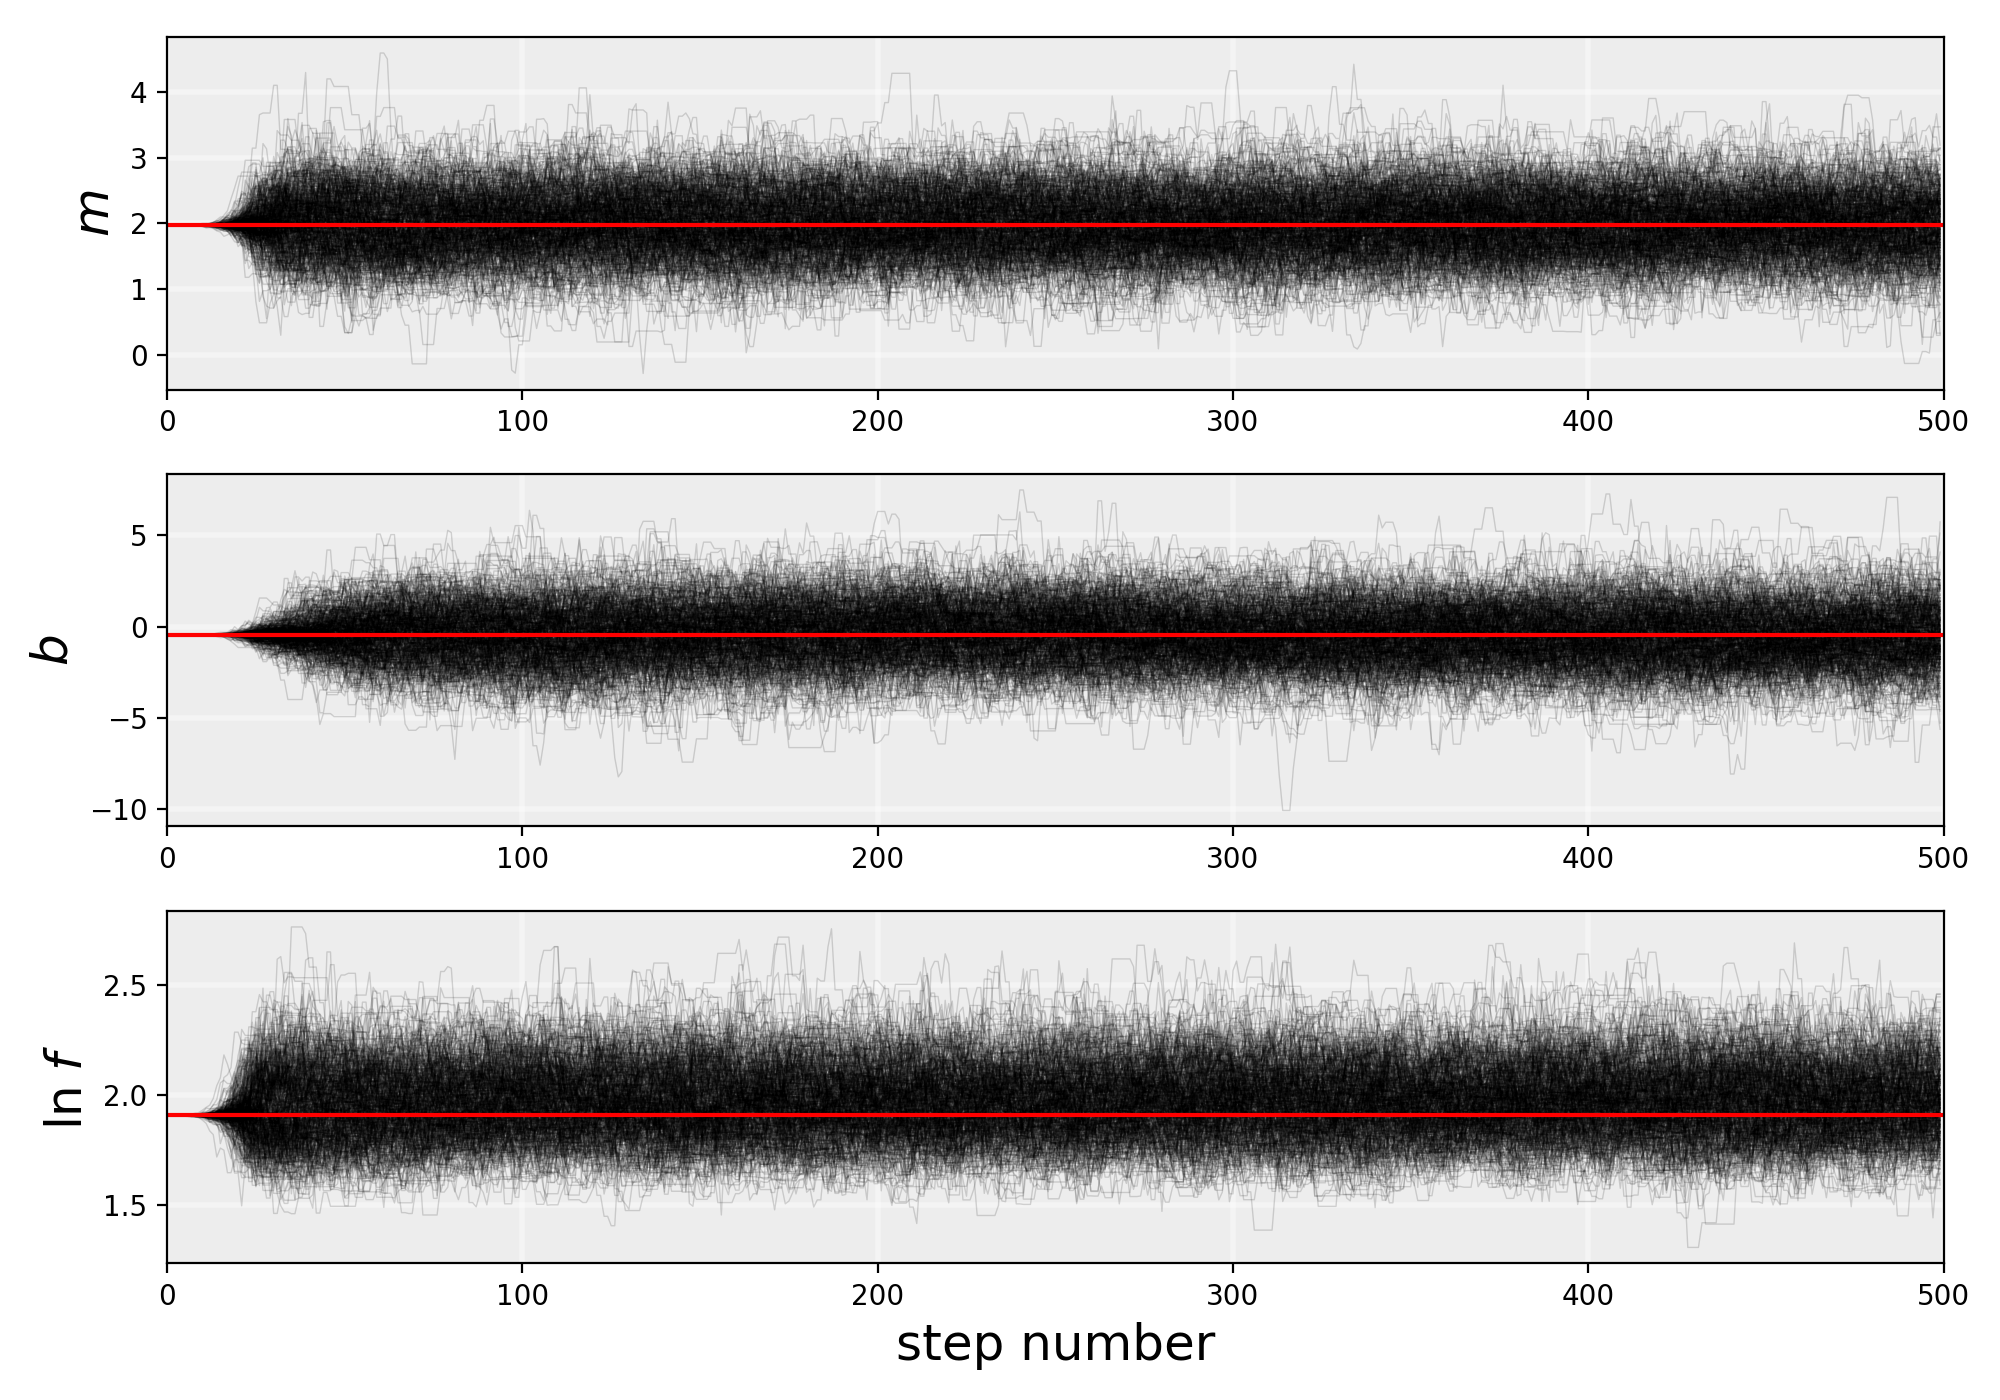

(500, 500, 3)


In [8]:
########################################################################################################################################################

fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(3,1,1)
ax1.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
ax2 = fig.add_subplot(3,1,2)
ax2.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
ax3 = fig.add_subplot(3,1,3)
ax3.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
fontsize=18

x_mcsteps = np.arange(0,np.shape(sampler.chain)[1],1)

for i in range(0,nwalkers,1):
    ax1.plot(x_mcsteps,sampler.chain[i,:,0],color='black',linewidth=0.5,alpha=0.15)
    ax2.plot(x_mcsteps,sampler.chain[i,:,1],color='black',linewidth=0.5,alpha=0.15)
    ax3.plot(x_mcsteps,sampler.chain[i,:,2],color='black',linewidth=0.5,alpha=0.15)
#     ax4.plot(x_mcsteps,sampler.chain[i,:,3],color='black',linewidth=0.5,alpha=0.5) # for intrinsic scatter in x AND y
ax1.set_ylabel(r'$m$',fontsize=fontsize)
ax2.set_ylabel(r'$b$',fontsize=fontsize)
ax3.set_ylabel(r'$\ln\;f$',fontsize=fontsize)

ax3.set_xlabel(r'step number',fontsize=fontsize) 
# fig.suptitle(r'$nwalkers=%d$'%nwalkers)
print np.shape(sampler.chain)
ax1.set_xlim(0,np.shape(sampler.chain)[1])
ax2.set_xlim(0,np.shape(sampler.chain)[1])
ax3.set_xlim(0,np.shape(sampler.chain)[1])

ax1.axhline(m_ml,color='red')
ax2.axhline(b_ml,color='red')
ax3.axhline(lnf_ml,color='red')

plt.tight_layout()

########################################################################################################################################################


<IPython.core.display.Javascript object>


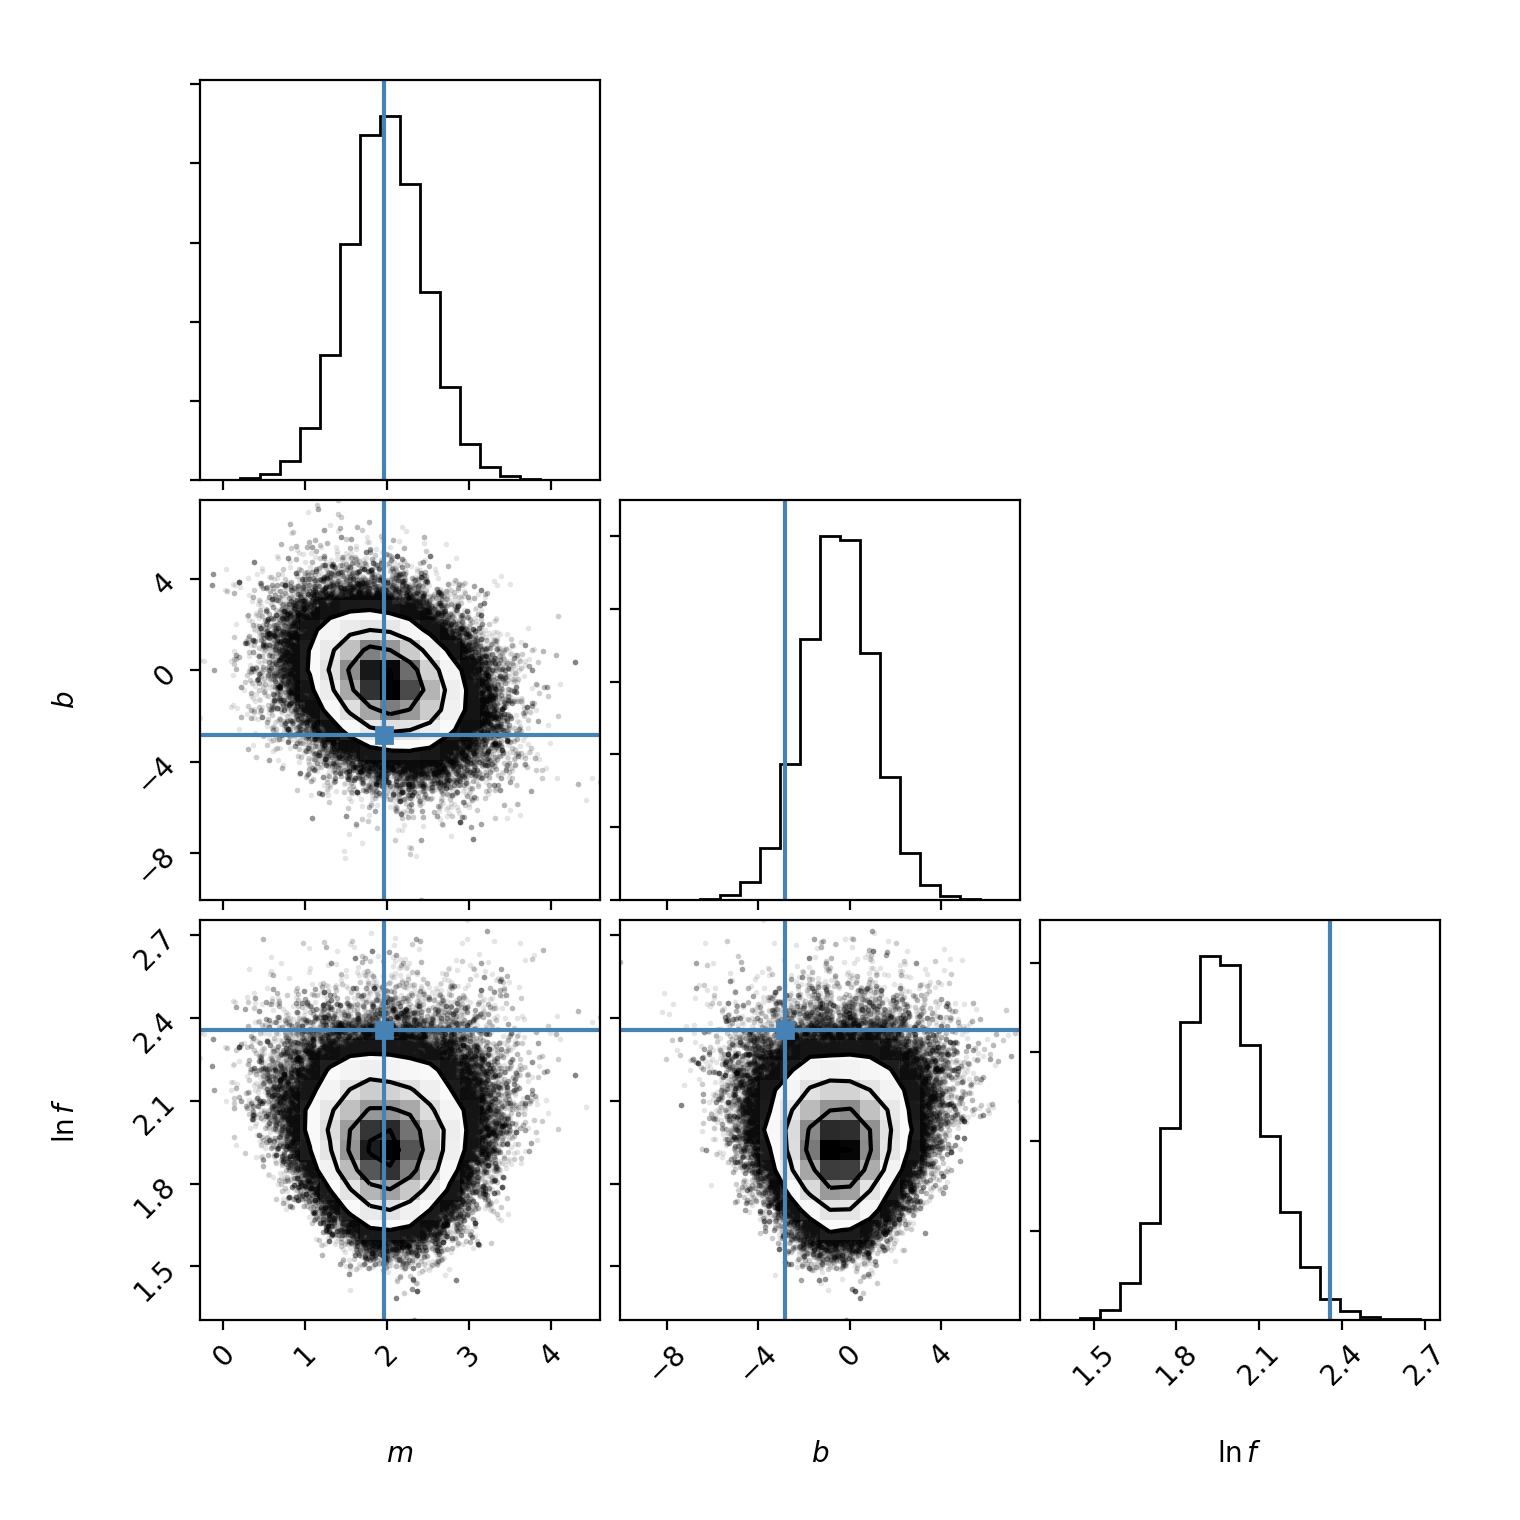

In [9]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],truths=[m_true, b_new, np.log(f_true)])

In [10]:
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

y_mcmc = m_mcmc[0]*X + b_mcmc[0]

In [11]:
print("""
#
    m = %0.3f , + %0.3f, - %0.3f (%0.1f sigma significance; %0.1f percent difference)
    b = %0.3f , + %0.3f, - %0.3f (%0.1f sigma significance; %0.1f percent difference)
    f = %0.3f , + %0.3f, - %0.3f (%0.1f sigma significance; %0.1f percent difference)
# """ % (m_mcmc[0], m_mcmc[1], m_mcmc[2], np.abs(m_mcmc[0]/(np.mean([m_mcmc[1],m_mcmc[2]]))), np.abs(m_mcmc[0]-m_true)/m_true*100.,\
         b_mcmc[0], b_mcmc[1], b_mcmc[2], np.abs(b_mcmc[0]/(np.mean([b_mcmc[1],b_mcmc[2]]))), np.abs(b_mcmc[0]-b_true)/b_true*100.,\
         (np.exp(f_mcmc[0])), (np.exp(f_mcmc[0])*(f_mcmc[1])), (np.exp(f_mcmc[0])*(f_mcmc[2])), np.abs(np.exp(f_mcmc[0])/(np.mean([(np.exp(f_mcmc[0])*(f_mcmc[1])), (np.exp(f_mcmc[0])*(f_mcmc[2]))]))), np.abs(np.exp(f_mcmc[0])-f_true)/f_true*100.)) 


#
    m = 1.981 , + 0.472, - 0.456 (4.3 sigma significance; 1.1 percent difference)
    b = -0.463 , + 1.486, - 1.503 (0.3 sigma significance; 110.8 percent difference)
    f = 7.089 , + 1.158, - 1.067 (6.4 sigma significance; 32.7 percent difference)
# 


In [12]:
def conf_bands(x,f,samples,conf=0.68):
    """ Generates confidence bands of a given fit.
    
    Computes the confidence band along a best fit function
    by computing the standard deviation of samples along the
    x-axis of a fit.
    
    Args:
        x: the x-axis of the data or the best fit function
        f: the function f(x) pertaining the best fit.  This 
            is the best fit function whose parameters are fit
            using emcee (must be same size as x).
        samples: monte-carlo fits to the data
            generated from emcee samples (see example for usage).
        conf: percentage of confidence (0,1] one wants to compute; if the number
            of samples in the flat_chain N<=30, a Student-t distribution is used, 
            and if N>30, a Normal (Gaussian) distribution is used.
    Returns:
        uci, lci: upper confidence interval, and lower confidence interval,
            centered on the best fit function provided by f.
    """
    # Check input
    if (f.size != x.size):
        raise ValueError(' x should be the same size as the best fit function f(x)!')
    if (samples[0].size != x.size):
        raise ValueError(' samples must be the same size as the array on which they are defined!')
    if  (conf >= 1) or (conf <= 0):
        raise ValueError(' chosen confidence interval must be in interval (0,99.9)!')
    print(" Computing confidence interval at %0.1f%%..." % (conf*100.0))
        
    # Compute the standard deviation along the stacked samples
    N = np.shape(samples)[0]
    print N
    # if N<=30, use a Student-t distribution to compute confidence intervals:
    if (N<=30):
        print(" Using a Student-t distribution to compute confidence intervals.")
        # Calculate standard error of the mean for all samples (along axis 0)
        sem = np.std(samples,ddof=1,axis=0)
        # iterate through best fit mean
        ucb = []
        lcb = []
        for i in range(0,len(f),1):
#             h = sem[i] * stats.t.ppf((1 + conf) / 2, N - 1)
            df = N - 1
            l,u = stats.t.interval(conf,df,loc=f[i],scale=sem[i])
#             print f[i],h
            lcb.append(l)
            ucb.append(u)
    # if N>30, use a normal (Gaussian) distribution to compute confidence intervals
    elif (N>30):
        print(" Using a normal (Gaussian) distribution to compute confidence intervals.")
        # Calculate standard error of the mean for all samples (along axis 0)
        sem = np.std(samples,axis=0)
        # iterate through best fit mean
        ucb = []
        lcb = []
        for i in range(0,len(f),1):
#             h = sem[i] * stats.t.ppf((1 + conf) / 2, N - 1)
            l,u = stats.norm.interval(conf,loc=f[i],scale=sem[i])
#             print f[i],h
            lcb.append(l)
            ucb.append(u)
        
    if 0: 
        fig = plt.figure(figsize=(5,5))
        ax1 = fig.add_subplot(1,1,1)
        ax1.plot(x,f,color='black')
        ax1.fill_between(x,ucb,lcb,color='blue',alpha=0.5)
    
    return ucb,lcb

<IPython.core.display.Javascript object>


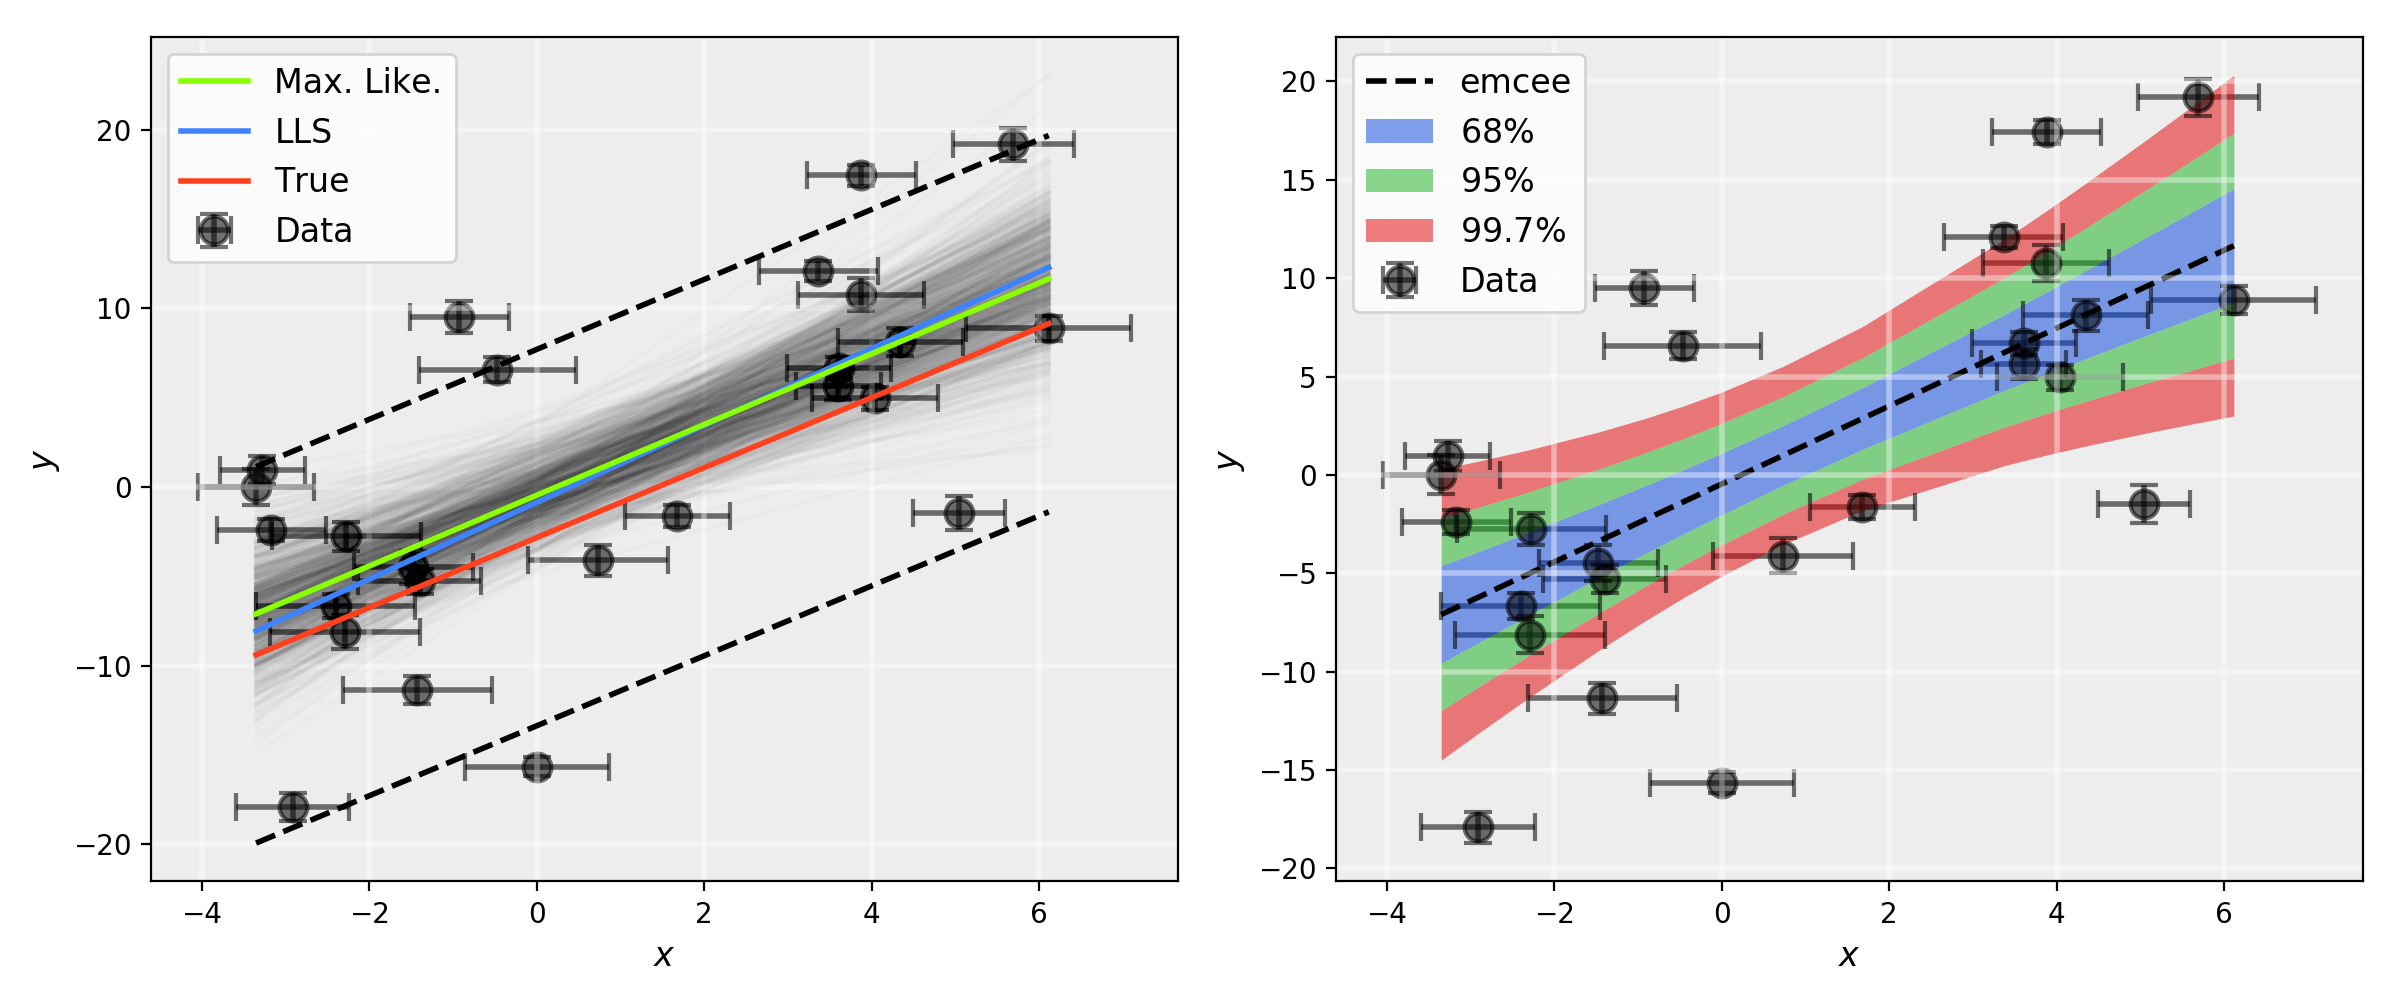

 Computing confidence interval at 68.0%...
1000
 Using a normal (Gaussian) distribution to compute confidence intervals.
 Computing confidence interval at 95.0%...
1000
 Using a normal (Gaussian) distribution to compute confidence intervals.
 Computing confidence interval at 99.7%...
1000
 Using a normal (Gaussian) distribution to compute confidence intervals.


In [13]:
########################################################################################################################################################

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1)
ax1.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
ax2 = fig.add_subplot(1,2,2)
ax2.patch.set_alpha(0.4)
plt.grid(True, color='w', linestyle='-', linewidth=2,alpha=0.4)
plt.gca().patch.set_facecolor('lightgray')
fontsize=12

ax1.errorbar(X,Y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)

s = 1000
for m, b, lnf in samples[np.random.randint(len(samples), size=s)]:
    ax1.plot(X, m*X+b, color="k", alpha=0.01,zorder=2)

ax1.plot(X,y_mcmc,color='xkcd:lime green',linewidth=2,label='Max. Like.',zorder=5)
ax1.plot(X,m_ls*X+b_ls,color='xkcd:dodger blue',linewidth=2,label='LLS',zorder=4)
ax1.plot(X,y_new,color='xkcd:orange red',linewidth=2,label='True',zorder=3)
ax1.plot(X,y_new+f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=3)
ax1.plot(X,y_new-f_true,color='xkcd:black',linewidth=2,linestyle='--',zorder=3)

ax1.set_xlabel('$x$',fontsize=fontsize)
ax1.set_ylabel('$y$',fontsize=fontsize)
ax1.legend(loc='best',fontsize=fontsize)

########################################################################################################
ax2.errorbar(X,Y,xerr=xerr,yerr=yerr,
             color='xkcd:black',fmt='o',markersize=10,capsize=5,elinewidth=2,ecolor='black',label=r'Data',alpha=0.55,
             markeredgecolor='black',markeredgewidth=1.5,zorder=1)

# Get 1000 samples of the best fit 
mcfits = []
for m, b, lnf in samples[np.random.randint(len(samples), size=s)]:
    mcfits.append(m*X+b)

ax2.plot(X,y_mcmc,color='xkcd:black',linewidth=2,linestyle='--',label='emcee',zorder=1)
lcb68,ucb68 = conf_bands(X,y_mcmc,mcfits,conf=0.68)
lcb95,ucb95 = conf_bands(X,y_mcmc,mcfits,conf=0.95)
lcb99,ucb99 = conf_bands(X,y_mcmc,mcfits,conf=0.997)

ax2.fill_between(X,ucb68,lcb68 ,color='xkcd:blue',alpha=0.5,interpolate=True,linewidth=0,label=r'$68\%$')

ax2.fill_between(X,ucb95,ucb68 ,color='xkcd:green',alpha=0.5,interpolate=True,linewidth=0,label=r'$95\%$')
ax2.fill_between(X,lcb68,lcb95 ,color='xkcd:green',alpha=0.5,interpolate=True,linewidth=0)

ax2.fill_between(X,ucb99,ucb95 ,color='xkcd:red',alpha=0.5,interpolate=True,linewidth=0,label=r'$99.7\%$')
ax2.fill_between(X,lcb95,lcb99 ,color='xkcd:red',alpha=0.5,interpolate=True,linewidth=0)

ax2.set_xlabel('$x$',fontsize=fontsize)
ax2.set_ylabel('$y$',fontsize=fontsize)
ax2.legend(loc='best',fontsize=fontsize)
plt.tight_layout()